In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import regex as re


# plotting utilities
%matplotlib inline
plt.rcParams["figure.figsize"] = (8, 4)
plt.rcParams["figure.titleweight"] = 'bold' 
plt.rcParams["figure.titlesize"] = 'x-large'
plt.rcParams['figure.dpi'] = 120
plt.style.use('fivethirtyeight')
font_t = {"size":18, "weight":"bold"}
font_l = {"name":"Arial", "size":14, "weight":"bold"}

In [2]:
def create_results_file(res, fname = "results.csv"):
    pd.DataFrame(data = {"Predicted":res}).to_csv(fname, index_label = "Id")

In [3]:
dev_file = r".\competition_dataset\dev.tsv"
eval_file = r".\competition_dataset\eval.tsv"

df_eval = pd.read_csv(eval_file, delimiter='\t')

df_dev = pd.read_csv(dev_file, delimiter='\t')
df_dev.head()

,country,description,designation,province,region_1,region_2,variety,winery,quality
0,France,"A creamed pear wine, with an attractive tang o...",Brut Blanc de Blancs,Alsace,Crémant d'Alsace,NaN,Pinot Blanc,Lucien Albrecht,45.0
1,US,"Simple and dry, this Cabernet has modest black...",NaN,California,Paso Robles,Central Coast,Cabernet Sauvignon,Castle Rock,31.0
2,US,"This lovely wine captures the floral, perfumed...",NaN,Oregon,Willamette Valley,Willamette Valley,Gewürztraminer,Château Bianca,35.0
3,Portugal,"The aromas are the thing here, as so often wit...",NaN,Alentejano,NaN,NaN,Touriga Nacional,Herdade do Esporão,41.0
4,Italy,"This is an interesting, outright strange wine ...",Natì,Southern Italy,Pompeiano,NaN,Coda di Volpe,Sorrentino,37.0


## Data Cleaning

In [4]:
df_dev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120744 entries, 0 to 120743
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   country      120739 non-null  object 
 1   description  120744 non-null  object 
 2   designation  84226 non-null   object 
 3   province     120739 non-null  object 
 4   region_1     100736 non-null  object 
 5   region_2     48736 non-null   object 
 6   variety      120744 non-null  object 
 7   winery       120744 non-null  object 
 8   quality      120744 non-null  float64
dtypes: float64(1), object(8)
memory usage: 8.3+ MB


#### Duplicated values

__first we convert all textual data to lower case__

In [6]:
columns = df_dev.columns[:-1]
columns

for c in columns:
    df_dev[c] = df_dev[c].str.lower()
    df_eval[c] = df_eval[c].str.lower()

In [7]:
df_dev.nunique()

country           48
description    85005
designation    27635
province         444
region_1        1206
region_2          18
variety          603
winery         14102
quality           86
dtype: int64

In [8]:
mask = df_dev.duplicated()
dups = df_dev[mask]
df_dev[mask].shape

(35716, 9)

In [9]:
dups.quality.describe()

count    35716.000000
mean        45.933223
std         11.891791
min          0.000000
25%         37.000000
50%         46.000000
75%         54.000000
max         96.000000
Name: quality, dtype: float64

__we have over 35,000 duplicated rows in our dev data set__  

In [10]:
df_dev.drop_duplicates(inplace= True)

In [11]:
df_dev.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 85028 entries, 0 to 120738
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   country      85025 non-null  object 
 1   description  85028 non-null  object 
 2   designation  59084 non-null  object 
 3   province     85025 non-null  object 
 4   region_1     71139 non-null  object 
 5   region_2     34294 non-null  object 
 6   variety      85028 non-null  object 
 7   winery       85028 non-null  object 
 8   quality      85028 non-null  float64
dtypes: float64(1), object(8)
memory usage: 6.5+ MB


In [14]:
df_dev.nunique()

country           48
description    85005
designation    27635
province         444
region_1        1206
region_2          18
variety          603
winery         14102
quality           86
dtype: int64

#### Missing values

In [15]:
df_dev.isna().sum(axis = 0)/df_dev.shape[0] * 100

country         0.003528
description     0.000000
designation    30.512302
province        0.003528
region_1       16.334619
region_2       59.667404
variety         0.000000
winery          0.000000
quality         0.000000
dtype: float64

In [16]:
# Let's see if we can all missing values in regione_1 have region_2 missing as well.
r1_missing = df_dev.region_1.isna().sum()
mask = df_dev.region_1.isna()
r2_missing = df_dev[mask]["region_2"].isna().value_counts()

r1_missing - r2_missing

True    0
Name: region_2, dtype: int64

__It seems they are both missing at the same time when region_1 is missing__

further analysis on missing data will be done in EDA and feature engineering.

## EDA


#### _Target_

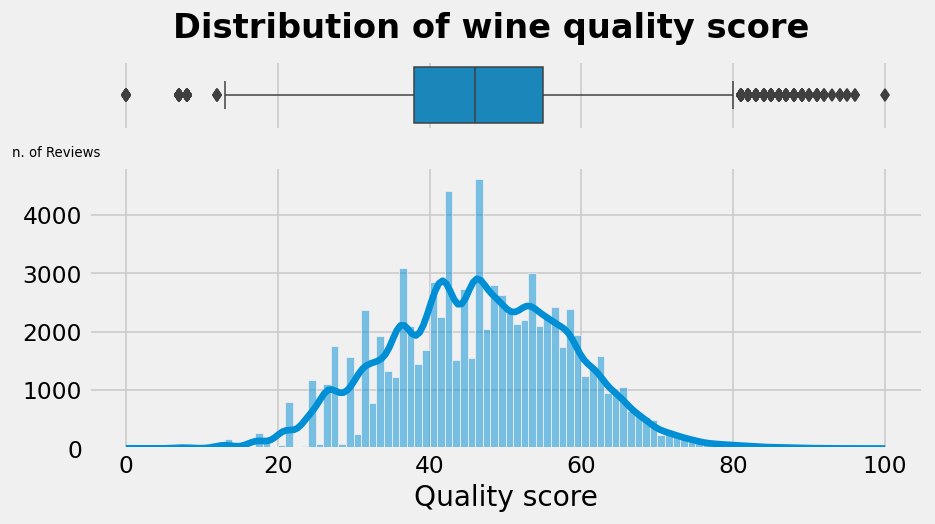

In [118]:
# Cut the window in 2 parts
try:
    df_dev["quality"] = y
except:
    pass

f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.20, .80)})
 
# Add a graph in each part
sns.boxplot(x = df_dev.quality, ax=ax_box, linewidth = 0.9)
sns.histplot(x = df_dev.quality, ax=ax_hist, bins = 100, kde = True)
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')



title = "Distribution of wine quality score"
l_x = "Quality score"
l_y = 'n. of Reviews'



plt.gcf().suptitle(title)
ax_hist.set_xlabel(l_x)
ax_hist.set_ylabel("")
ax_hist.text(-15,5000,l_y, fontdict={"weight":"normal", "size":8})
plt.savefig("qualityDist.jpg", bbox_inches = 'tight')
plt.show()

In [18]:
df_dev.quality.describe()

count    85028.000000
mean        46.422614
std         11.935714
min          0.000000
25%         38.000000
50%         46.000000
75%         55.000000
max        100.000000
Name: quality, dtype: float64

In [19]:
df_dev[df_dev.quality > 55].quality.count()

19931

In [20]:
_,mean, std,*d = df_dev.quality.describe()

In [21]:
#lets check how many values are withing mean +- 3*sd

lower = mean - 3*std
upper = mean + 3*std

mask = (df_dev.quality > lower) & (df_dev.quality < upper)
df_dev[mask].describe()

,quality
count,84810.000000
mean,46.376489
std,11.776290
min,12.000000
25%,38.000000
50%,46.000000
75%,55.000000
max,82.000000


In [22]:
1- 84810/85028

0.0025638613162722868

just a few values are outside that interval.  

<AxesSubplot:ylabel='Frequency'>

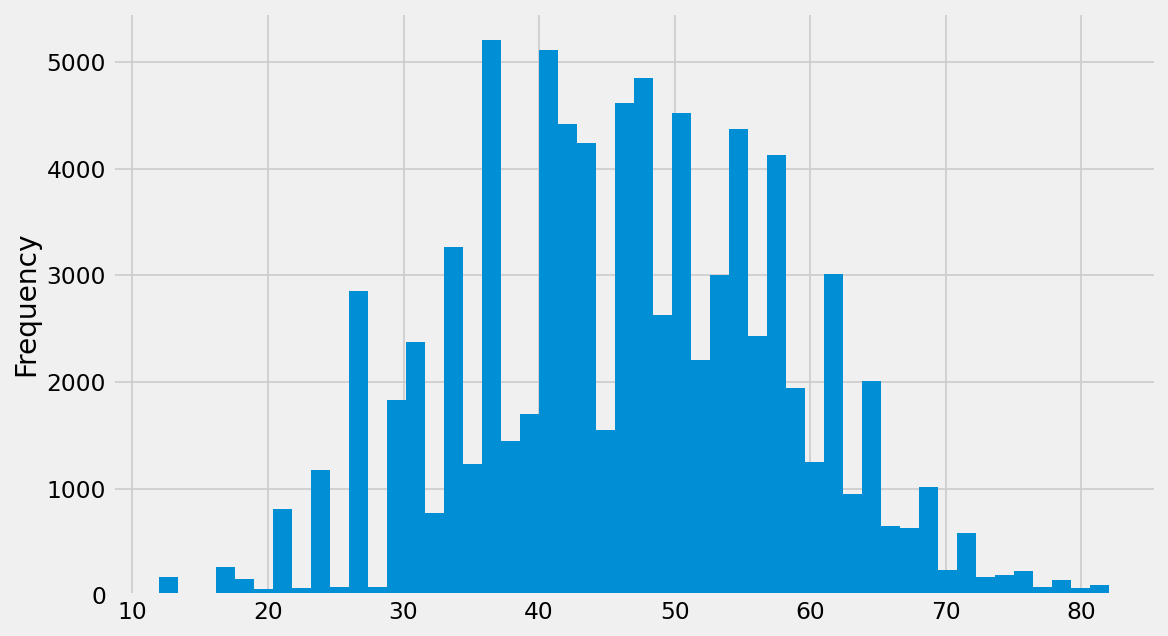

In [23]:
df_dev[mask].quality.plot(kind = 'hist', bins = 50)

#### 1. country

In [24]:
df_dev.country.isna().sum()

3

In [26]:
df_dev.country.unique()

array(['france', 'us', 'portugal', 'italy', 'new zealand', 'argentina',
       'chile', 'austria', 'south africa', 'australia', 'germany',
       'spain', 'greece', 'canada', 'croatia', 'moldova', 'israel',
       'turkey', 'egypt', 'slovakia', 'hungary', 'serbia', 'mexico',
       'romania', 'bulgaria', 'georgia', 'slovenia', 'morocco',
       'lithuania', 'lebanon', 'macedonia', 'brazil', 'cyprus',
       'czech republic', 'luxembourg', 'uruguay', 'ukraine', 'japan',
       'india', 'us-france', 'england', 'china', 'south korea', 'missing',
       'tunisia', 'bosnia and herzegovina', 'switzerland', 'montenegro',
       'albania'], dtype=object)

In [120]:
plt.figure(figsize= (12,10))
n_larg = df_dev.country.value_counts().nlargest(10)
mask = [x not in n_larg.index for x in df_dev.country.unique()]
others = df_dev.country.value_counts()[mask]

n_larg["Others"] = others.sum()

n_larg[::-1]

Others          4677
new zealand     1674
austria         1713
australia       2728
portugal        3024
argentina       3063
chile           3249
spain           4710
france         12361
italy          13062
us             35202
Name: country, dtype: int64

<Figure size 1440x1200 with 0 Axes>

In [121]:
N = df_dev.country.count()

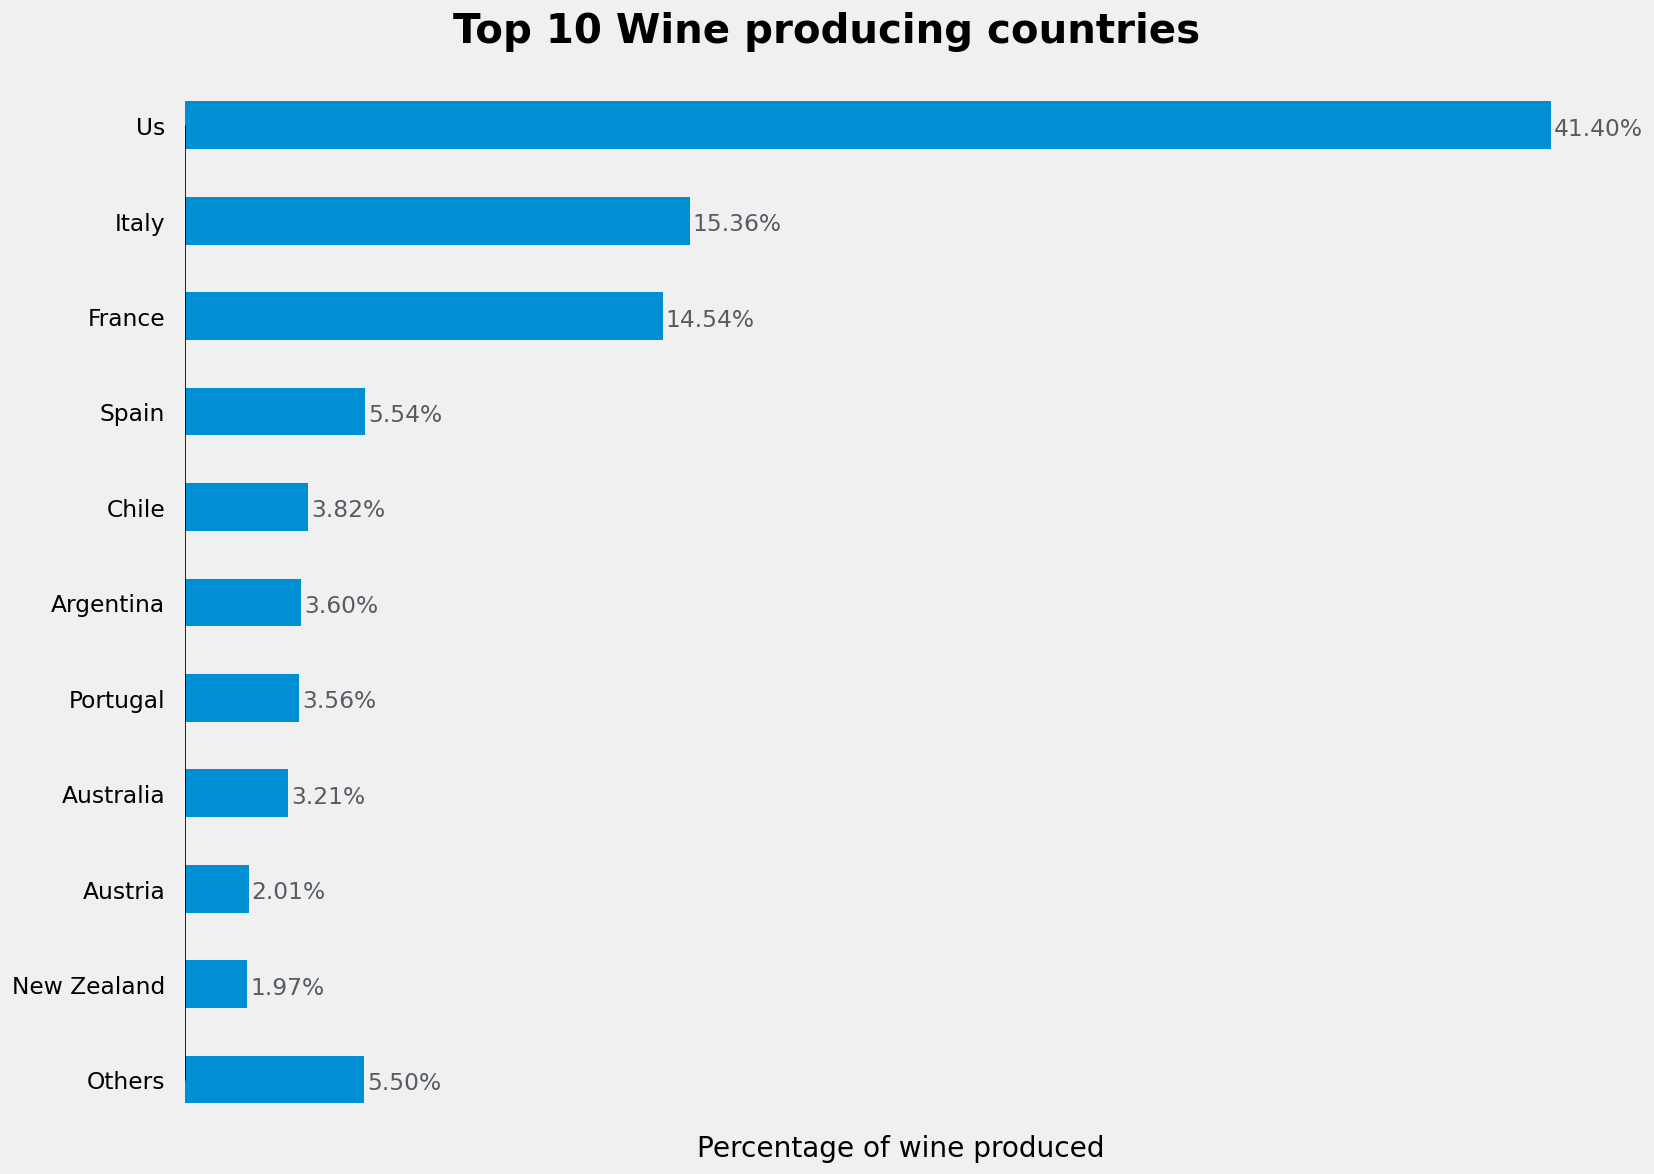

In [156]:
plt.figure(figsize= (14,10))
n_larg = df_dev.country.value_counts().nlargest(10)
mask = [x not in n_larg.index for x in df_dev.country.unique()]
others = df_dev.country.value_counts()[mask]

n_larg["Others"] = others.sum()

n_larg[::-1].plot(kind= 'barh', xticks = [])

for i, v in enumerate(n_larg[::-1]):
    plt.text(v + 80, i - .1, f"{v/N *100:.2f}%", color='#555c63', fontweight='normal')

plt.grid()


title = "Top 10 Wine producing countries"
l_x = "Percentage of wine produced"
l_y = ''

locs, labels = plt.yticks()  # Get the current locations and labels.
labels = [l.get_text().title() for l in labels]
plt.yticks(locs, labels)  

yax = plt.gca().get_yaxis()
pad = 10
yax.set_tick_params(pad=pad)

plt.vlines(0,0,10, color = 'black')

plt.suptitle(title, fontsize = 'xx-large')
plt.xlabel(l_x)
plt.ylabel(l_y)
plt.tight_layout()
plt.savefig("t10Countries.jpg", bbox_inches = 'tight', format = 'jpg')
plt.show()

__lets check the average quality score per country__

In [30]:
mean_country_score = df_dev.groupby("country")["quality"].mean()
mean_country_score.nlargest(10)

country
us-france      59.000000
england        58.000000
luxembourg     55.000000
france         49.750263
canada         49.048780
switzerland    48.666667
hungary        48.336000
mexico         48.275000
italy          48.167126
us             47.987870
Name: quality, dtype: float64

In [31]:
mean_country_score.nsmallest(10)

country
lithuania                 27.000000
montenegro                27.000000
bulgaria                  28.918367
romania                   29.884211
bosnia and herzegovina    32.333333
ukraine                   33.000000
india                     33.200000
china                     33.500000
south korea               34.000000
moldova                   34.487179
Name: quality, dtype: float64

#### 2. province

In [32]:
df_dev.province.isna().sum()

3

In [34]:
df_dev.province.value_counts()

california                  25031
washington                   5597
tuscany                      4071
bordeaux                     3734
northern spain               2771
                            ...  
cyclades                        1
monemvasia                      1
slovenska istra                 1
egilias slopes                  1
marlborough & hawkes bay        1
Name: province, Length: 445, dtype: int64

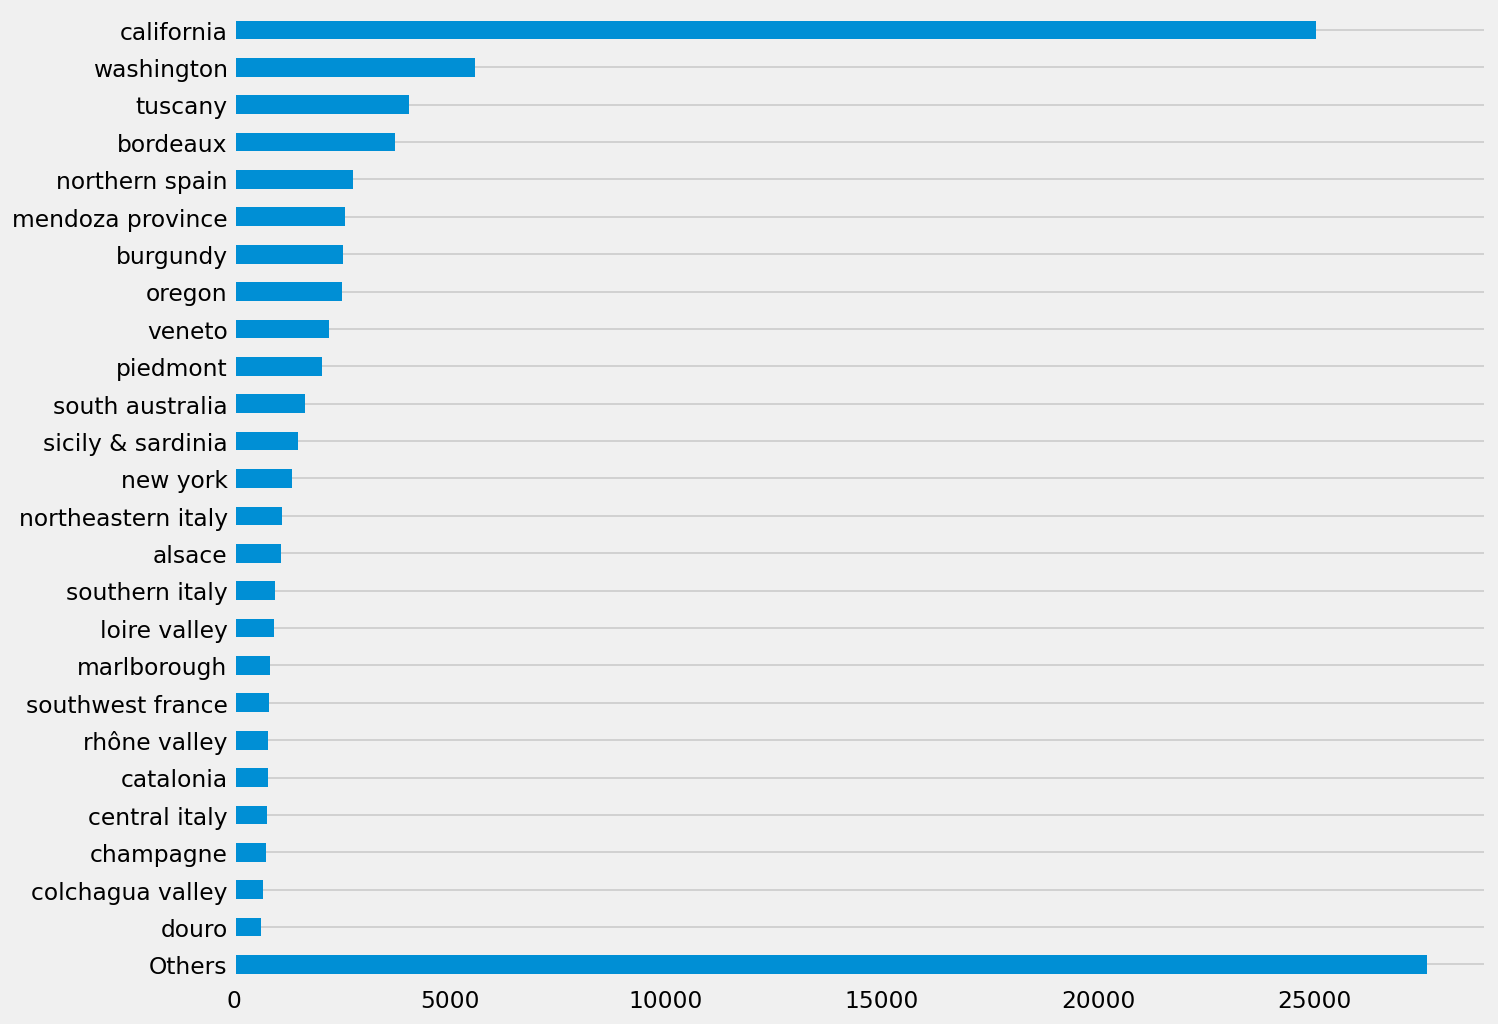

In [35]:
plt.figure(figsize= (12,10))
n_larg = df_dev.province.value_counts().nlargest(25)
mask = [x not in n_larg.index for x in df_dev.province.unique()]
others = df_dev.province.value_counts()[mask]

n_larg["Others"] = others.sum()

n_larg[::-1].plot(kind= 'barh')
plt.grid(axis = 'x');

#### 3. variety

In [36]:
df_dev.variety.value_counts().nlargest(200)

pinot noir                  8072
chardonnay                  7994
cabernet sauvignon          7203
red blend                   5665
bordeaux-style red blend    4347
                            ... 
rkatsiteli                    15
carricante                    15
roditis                       15
plavac mali                   14
corvina                       14
Name: variety, Length: 200, dtype: int64

In [37]:
df_dev.variety.isna().sum()

0

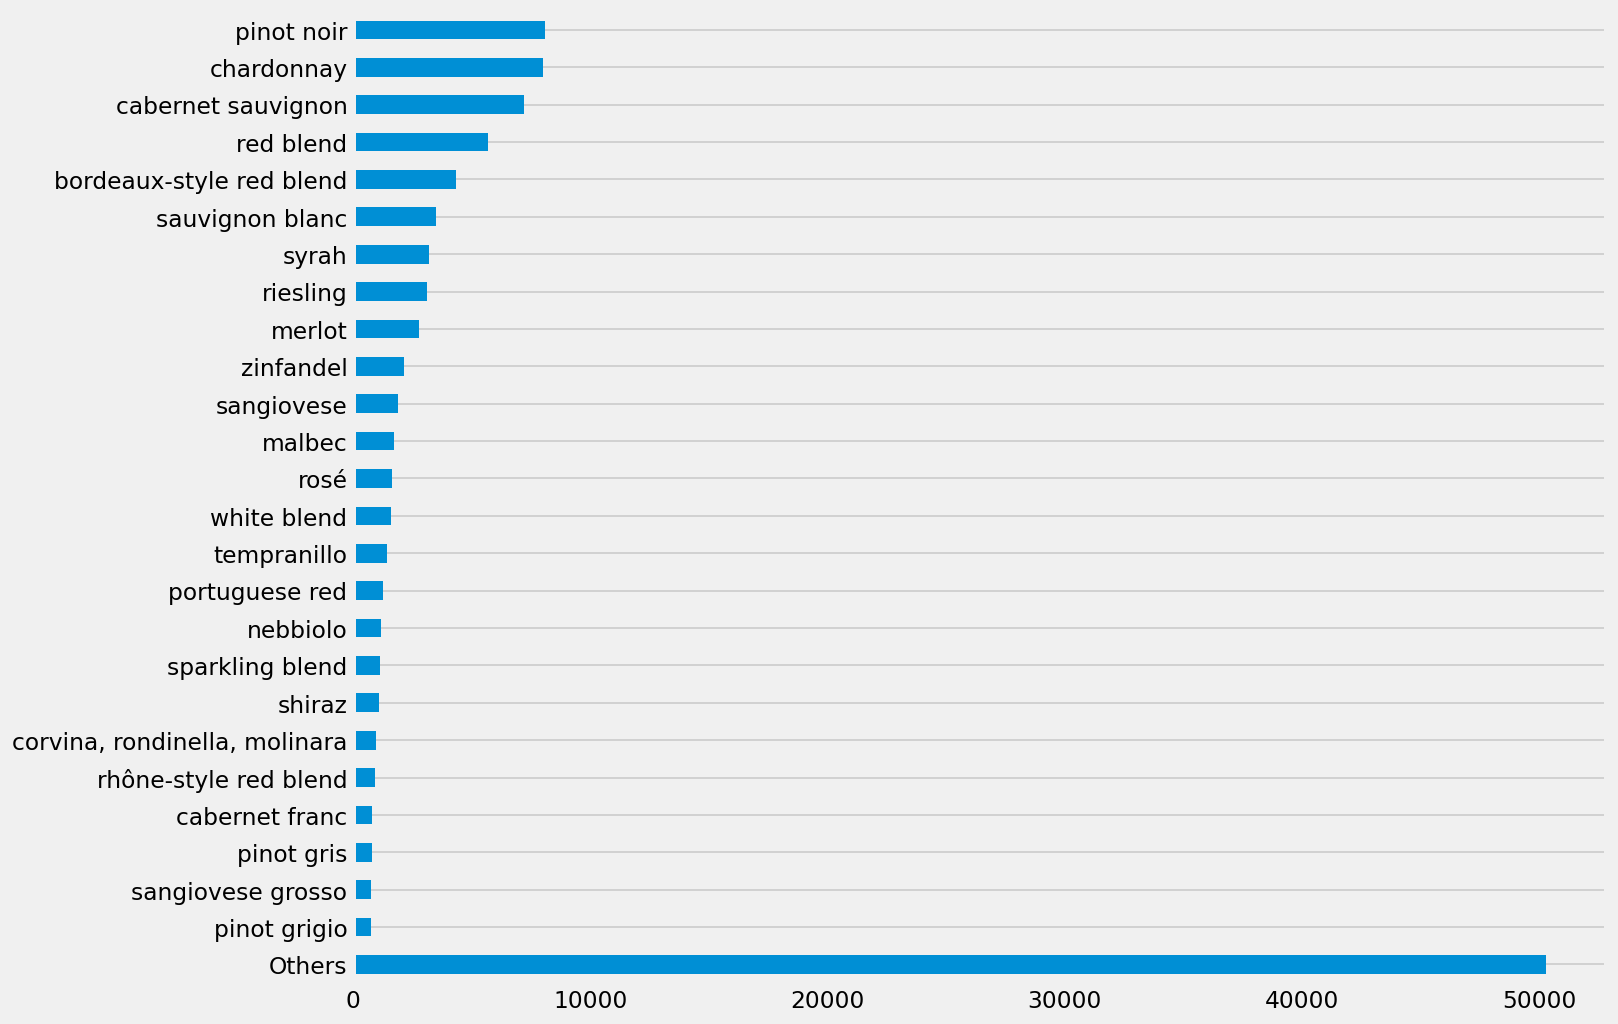

In [38]:
plt.figure(figsize= (12,10))
n_larg = df_dev.variety.value_counts().nlargest(25)
mask = [x not in n_larg.index for x in df_dev.variety.unique()]
others = df_dev.variety.value_counts()[mask]

n_larg["Others"] = others.sum()

n_larg[::-1].plot(kind= 'barh')
plt.grid(axis = 'x');

#### 4. winery

In [39]:
df_dev.winery.isna().sum()

0

In [40]:
df_dev.winery.value_counts()

williams selyem             210
testarossa                  149
chateau ste. michelle       135
columbia crest              130
dfj vinhos                  126
                           ... 
verdad                        1
chasing lions                 1
sivi                          1
bowtie                        1
château mazeris bellevue      1
Name: winery, Length: 14102, dtype: int64

#### 5. designation

In [41]:
df_dev.designation.nunique()

27635

In [42]:
df_dev.designation.value_counts().nlargest(10)

reserve           1543
barrel sample     1151
reserva            990
estate             880
riserva            450
brut               339
estate grown       277
crianza            266
estate bottled     215
dry                212
Name: designation, dtype: int64

#### 7. description

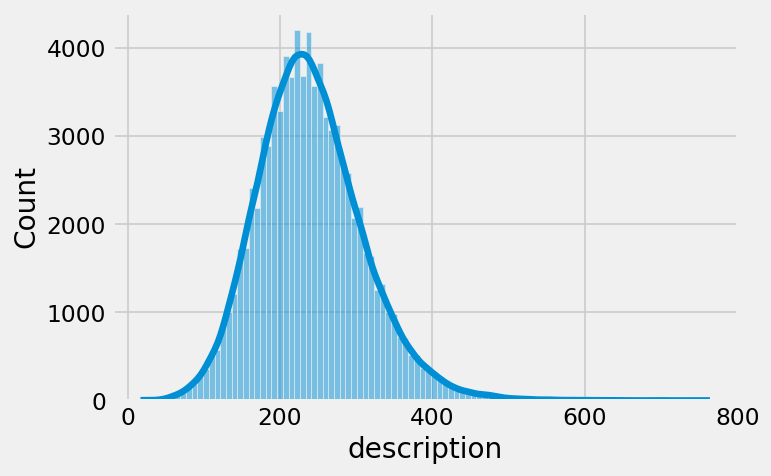

In [44]:
desc_len = df_dev.description.str.len()

plt.figure(figsize=(6,4))
sns.histplot(desc_len, bins = 100, kde=True);

In [45]:
desc_len.shape

(85028,)

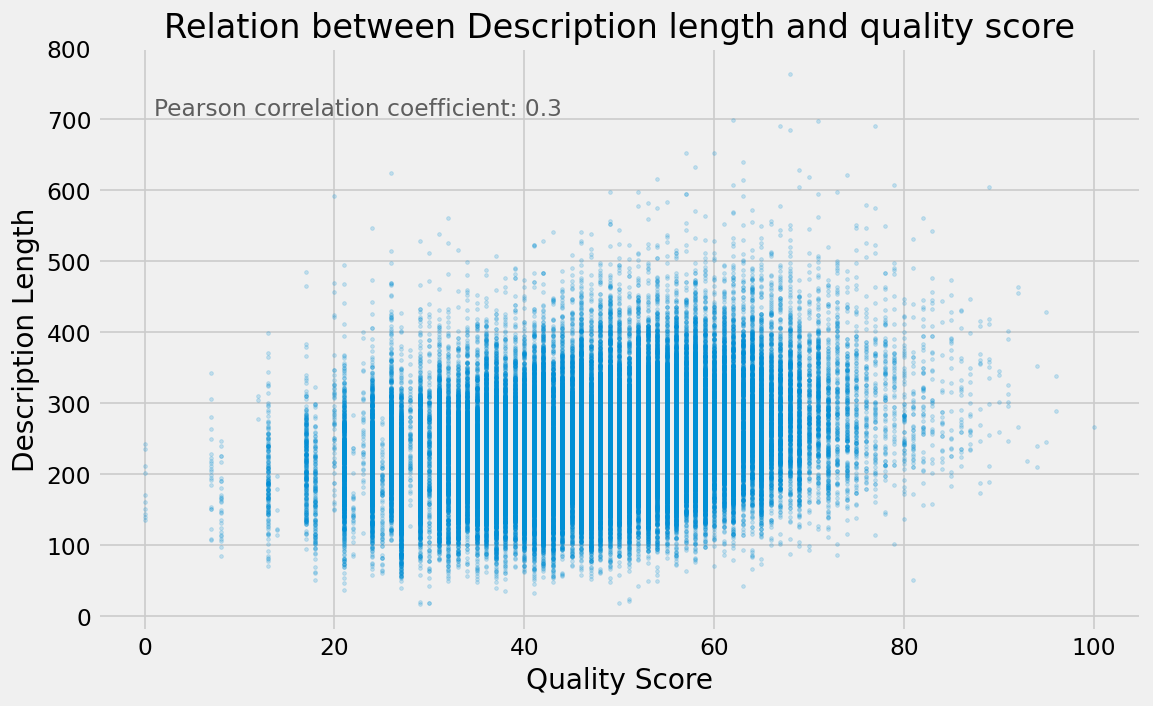

In [46]:
title = "Relation between Description length and quality score"
l_x = "Quality Score"
l_y = 'Description Length'

plt.scatter(df_dev.quality, desc_len,  s = 5, alpha= 0.2);
plt.text(1,705, "Pearson correlation coefficient: 0.3", color = '#5e5e5e')

plt.title(title)
plt.xlabel(l_x)
plt.ylabel(l_y)
plt.show()



In [47]:
np.corrcoef(df_dev.quality, desc_len)

array([[1.        , 0.29520963],
       [0.29520963, 1.        ]])

their is a mild correlation between description length and quality scores.

__word cloud for description text__

In [133]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [134]:
lines = df_dev.description
text = ".".join(lines)

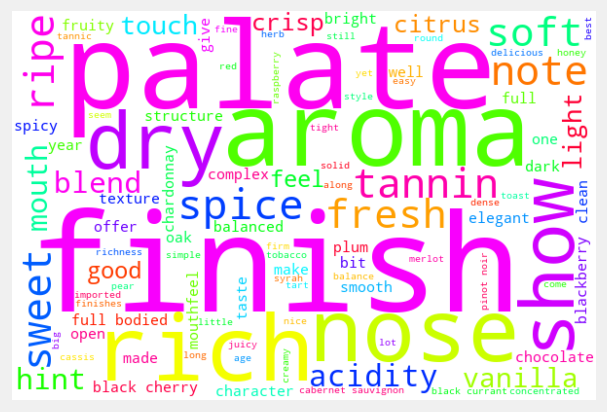

In [135]:
stopwords = set(STOPWORDS)
stopwords.update(["flavor", "wine", "flavors", 'fruit', "drink", 'now'])

# Generate a word cloud image
wc = WordCloud(background_color="white",
               max_words=100,
               height=400,
               width=600,
               stopwords=stopwords,
               colormap='hsv'
               )
colud_image = wc.generate(text)

# Display the generated image:
# the matplotlib way:
plt.imshow(colud_image, interpolation='bilinear')
plt.axis("off")

#plt.suptitle("Wine vocabulary", fontsize = 'xx-large')
plt.savefig("wv.png", bbox_inches = 'tight')
plt.show()

In [12]:
# we introduce a new category 'missing' to fill na categorical values
df_dev.country.fillna(value = 'missing', inplace = True)
df_eval.country.fillna(value = 'missing', inplace = True)

df_dev.province.fillna("missing", inplace=True)
df_eval.province.fillna("missing", inplace=True)


df_dev.designation.fillna("missing", inplace=True)
df_eval.designation.fillna("missing", inplace=True)

## Feature Engineering

In [13]:
# Models and metrics

from scipy.sparse import hstack
import nltk
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.porter import PorterStemmer
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
from scipy.sparse import hstack
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import TruncatedSVD

rs = 999

In [14]:
y = df_dev.pop("quality").values

__let's introduce a feature location, which will use all possible location information to fill missing values__

In [15]:
df_dev["location"] = df_dev.region_1

In [16]:
def make_mask(df):
    mask = df.location.isna()
    print("total na values:", mask.sum())
    return mask

In [17]:
# try filling with province, where province is available


mask = make_mask(df_dev) & ( df_dev.province != 'missing')
df_dev.loc[mask, 'location'] = df_dev[mask].province

total na values: 13889


In [18]:
df_dev[df_dev.region_1.isna()].head(5)

,country,description,designation,province,region_1,region_2,variety,winery,location
3,portugal,"the aromas are the thing here, as so often wit...",missing,alentejano,NaN,NaN,touriga nacional,herdade do esporão,alentejano
5,new zealand,classic gooseberry and pink grapefruit notes f...,missing,marlborough,NaN,NaN,sauvignon blanc,cloudy bay,marlborough
19,chile,"cedar, cassis and blueberry aromas open this m...",catalina,rapel valley,NaN,NaN,bordeaux-style red blend,santa ema,rapel valley
20,austria,"with its 18 months wood aging, this is a velve...",reserve,carnuntum,NaN,NaN,pinot noir,markowitsch,carnuntum
32,chile,"gold in color, this blend of 50% riesling and ...",late harvest,curicó valley,NaN,NaN,white blend,montes,curicó valley


In [19]:
# let's do the same for eval dataset

df_eval["location"] = df_eval.region_1
mask = (make_mask(df_eval)) & (df_eval.province != 'missing')
df_eval.loc[mask, 'location'] = df_eval[mask].province

total na values: 5052


In [20]:
stmr = PorterStemmer()
def stemmer(line):
    clean_line = re.sub('[^a-zA-Z]'," ",line)
    words = [stmr.stem(x) for x in clean_line.lower().split()]
    
    return " ".join(words)

In [21]:
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
def make_tokens(text):
    tokens = tokenizer.tokenize(text)
    return [x for x,y in nltk.pos_tag(tokens) if y in ['JJ', 'JJS', 'RB', 'RBR']]

#### Feature_maker

In [22]:
class Feature_maker:
    def __init__(self, pre_processor = None, 
                 tfidf_min_df = 0, 
                 tokenizer = None,
                 tfidf_ng_range = (1,1)
                ):
        
        self.tfidf = TfidfVectorizer(stop_words='english',
                                     tokenizer= tokenizer,
                                     preprocessor= pre_processor,                                    
                                     min_df= tfidf_min_df,
#                                      use_idf = False,
#                                      norm= None,
#                                      binary= True
                                      ngram_range= tfidf_ng_range,
#                                      max_df= 0.9,

                                    )
        self.top_words = None
        self.ohe = OneHotEncoder(handle_unknown= 'ignore')
        self.text_col = None
        self.cols = None
        
        
    def desc_encoding(self, text):
        """ Computes tfidf matrix from given text
        Returns selected words and sparse matrix.
        """
        res = self.tfidf.fit_transform(text)
        words = self.tfidf.get_feature_names()
        return words, res

    
    
    def fit_transform(self,df,cat_cols, text_col = 'description'):
        """ Makes feature matrix
        Parameters
        ----------
        df: input dataframe
        cat_cols: columns list to be selected and encoded by OHE
        text_col: column name with textual data
        
        Returns
        -------
        Sparse tfidf matrix
        Sparse ohe matrix
        Sparse matrix with both tfidf and ohe columns.
        """
        self.text_col = text_col
        self.f_columns = cat_cols
        
        self.top_words, self.desc_tfidf = self.desc_encoding(df[self.text_col])
        cats_ohe = self.ohe.fit_transform(df[self.f_columns])
        
        
        #self.mask = [x in ['JJ', 'JJS', 'RB', 'RBR'] for _, x in nltk.pos_tag(self.top_words)]
        #return self.desc_tfidf[:,mask]#hstack((self.desc_tfidf[:,mask], cats_ohe))
        
        return (self.desc_tfidf, cats_ohe, hstack((self.desc_tfidf, cats_ohe)))
    
    
    def transform(self, df):
        """ used only for evaluation dataframe for final predictions
        """
        desc_tfidf = self.tfidf.transform(df[self.text_col])
        cats_ohe = self.ohe.transform(df[self.f_columns])
        
        return hstack((desc_tfidf, cats_ohe))
    
    def get_feature_names(self):
        """ returns list of columns names w.r.t 3-rd output matrix of fit_transform.
        """
        return self.top_words + self.ohe.get_feature_names(self.f_columns).tolist()

#### select_features

In [23]:
def select_features(df, cols, n_features, kind='both', min_df=0.01, ng_range=(1, 1)):
    """ Select given columns out of df and prepare feature matrix with n_features
    Parameters
    ----------
    df: Source dataframe 
    cols: list of columns with categorical features 
    n_features: N. of features to be selected through SVD. ('all' to select all)
    kind: to select only tfidf use 'desc', for only ohe use 'cats' and use 'both' for merged set
    min_df: Min document frequency for tfidf 0.01, 
    ng_range: ngrams types for tfidf. Default is (1,1).

    Returns
    -------
    X_train, training fm
    X_test, testing fm
    y_train, training target values
    y_test, testing true target values
    fmk, feature selection Object
    """
    kind_dict = {
        "desc": 0,
        "cats": 1,
        "both": 2
    }

    fmk = Feature_maker(tfidf_min_df=min_df,
                        tfidf_ng_range=ng_range,
#                         pre_processor = stemmer
                        )
    feature_mats = fmk.fit_transform(df, cols)
    X = feature_mats[kind_dict[kind]]
    print(X.shape, kind_dict[kind])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2,
                                                        shuffle=True, random_state=999)
    if n_features == 'all':
        return X_train, X_test, y_train, y_test, fmk

    svd = TruncatedSVD(n_components=n_features, random_state=999)
    X_train_tr = svd.fit_transform(X_train, y_train)
    X_test_tr = svd.transform(X_test)

    return X_train_tr, X_test_tr, y_train, y_test, fmk

__Selecting the (location,variety) columns and tfidf matrix, with a total of 50 features.__

In [147]:
cols = ['location', 'variety']

X_train_tr, X_test_tr, y_train, y_test, _ = select_features(df_dev, cols, 50)

In [148]:
X_train_tr.shape

(68022, 50)

__Training 5 different Models__

In [152]:
models = {
    "OLS linear reg." : LinearRegression(n_jobs= -1),
    "ridge": make_pipeline(PolynomialFeatures(), Ridge(random_state=rs)),
    "lasso": make_pipeline(PolynomialFeatures(), Lasso(random_state=rs)),
    "svr": SVR(),
    "knn": KNeighborsRegressor(n_jobs= -1),
    "rf reg.": RandomForestRegressor(n_estimators= 20, random_state=rs, n_jobs= -1)
}

In [153]:
scorer = {}
for model in models:
    print("Currently testing:", model)
    est = models[model]
    est.fit(X_train_tr, y_train)
    y_hat = est.predict(X_test_tr)
    scorer[model] = r2_score(y_test, y_hat)

Currently testing: OLS linear reg.
Currently testing: ridge
Currently testing: lasso
Currently testing: svr
Currently testing: knn
Currently testing: rf reg.


In [154]:
scorer

{'OLS linear reg.': 0.355600082617171,
 'ridge': 0.45949445216459084,
 'lasso': -3.808564638996259e-06,
 'svr': 0.4213820805404045,
 'knn': 0.4057966692235593,
 'rf reg.': 0.4470580738821951}

__For ridge, checking the weights given to features of different columns__  
without tfidf matrix.

In [87]:
%%time

cols = ["country", "region_1", 'designation', 'location', 'variety', 'winery']

X_train_tr, X_test_tr, y_train, y_test, fmk = select_features(df_dev, cols,
                                                              n_features='all',
                                                              kind='cats'
                                                              )
ridge = make_pipeline(Ridge(random_state=rs))
ridge.fit(X_train_tr, y_train)
y_hat = ridge.predict(X_test_tr)
r2 = r2_score(y_test, y_hat)

print("With features:", cols, "\nr2-score:", r2)

(85028, 45188) 1
With features: ['country', 'region_1', 'designation', 'location', 'variety', 'winery'] 
r2-score: 0.7375554845787766
Wall time: 4.45 s


In [88]:
#list of feature names
#slicing the tfidf words out (they are not in fm)
features = fmk.get_feature_names()[len(fmk.top_words):]
scores = ridge.named_steps["ridge"].coef_

weights_df = pd.DataFrame(data = {"features":features,"weights": scores})
weights_df.head()

,features,weights
0,country_albania,0.804643
1,country_argentina,-7.893348
2,country_australia,-1.887270
3,country_austria,7.539045
4,country_bosnia and herzegovina,-1.326709


In [89]:
weights_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45188 entries, 0 to 45187
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   features  45188 non-null  object 
 1   weights   45188 non-null  float64
dtypes: float64(1), object(1)
memory usage: 706.2+ KB


<AxesSubplot:xlabel='weights', ylabel='Count'>

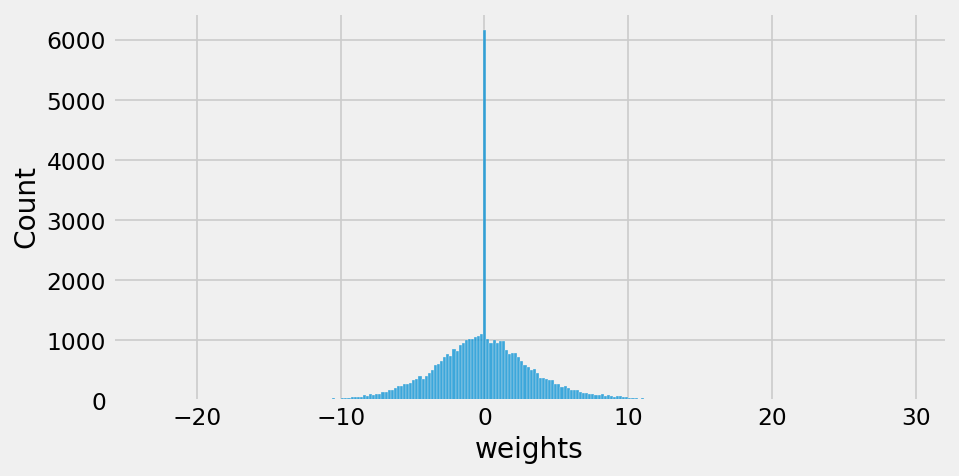

In [90]:
sns.histplot(data = weights_df, x = "weights")

In [91]:
weights_df["attribute"] = weights_df.features.str.split("_").str[0]

In [92]:
mask = weights_df.weights.abs() > 1

In [93]:
imp_atts = weights_df[mask]
imp_atts.head()

,features,weights,attribute
1,country_argentina,-7.893348,country
2,country_australia,-1.887270,country
3,country_austria,7.539045,country
4,country_bosnia and herzegovina,-1.326709,country
6,country_bulgaria,-8.636298,country


In [94]:
imp_atts.shape

(30502, 3)

In [95]:
att_weights = imp_atts.groupby("attribute")["weights"].apply(lambda x: abs(x).sum())
att_weights

attribute
country          131.412881
designation    66691.566403
location        3233.064161
region          2372.662928
variety         1248.080039
winery         41060.305110
Name: weights, dtype: float64

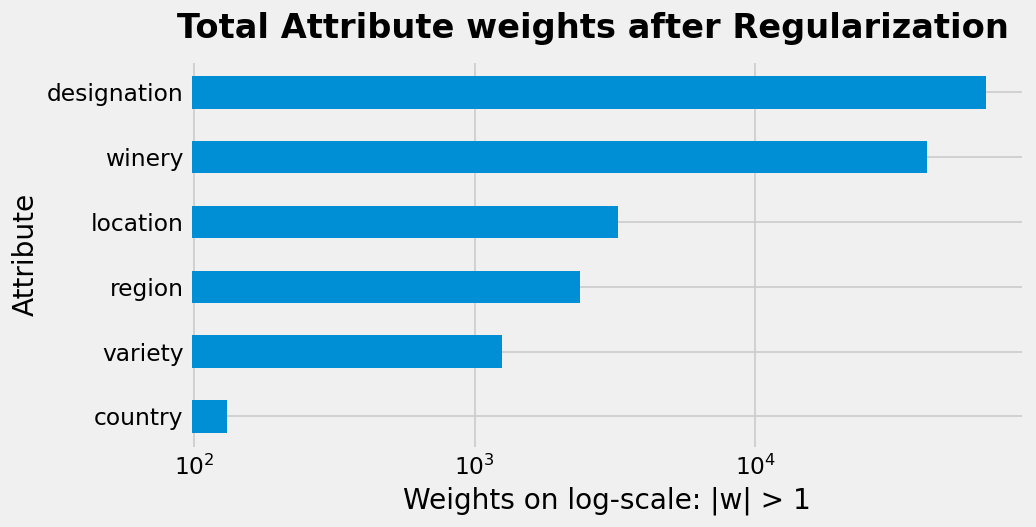

In [98]:
#ax = sns.catplot(att_weights);
att_weights.sort_values().plot(kind = 'barh', logx = True)
plt.xscale("log")

title = "Total Attribute weights after Regularization"
l_x = "Weights on log-scale: |w| > 1"
l_y = 'Attribute'


plt.suptitle(title, fontsize = 'x-large')
plt.xlabel(l_x)
plt.ylabel(l_y)
plt.savefig("ridgeAllCats.png", bbox_inches = 'tight')
plt.show()

__For ridge, checking the weights given to words__  
without ohe matrix.

In [25]:
%%time

X_train_tr, X_test_tr, y_train, y_test, fmk = select_features(df_dev, cols,
                                                              n_features='all',
                                                              kind='desc', 
                                                              min_df=0
                                                              )
ridge = Ridge(random_state=rs)
ridge.fit(X_train_tr, y_train)
y_hat = ridge.predict(X_test_tr)
r2 = r2_score(y_test, y_hat)

print("With words:", cols, "\nr2-score:", r2)

(85028, 28903) 0
With words: ['country', 'region_1', 'designation', 'location', 'variety', 'winery'] 
r2-score: 0.46899857104030884
Wall time: 4.34 s


In [26]:
#list of words
features = fmk.top_words
scores = ridge.coef_

words_df = pd.DataFrame(data = {"features":features,"weights": scores})
words_df.head()

,features,weights
0,00,0.274929
1,000,-23.894786
2,002,-1.995171
3,01,7.631224
4,01s,6.265164


<AxesSubplot:ylabel='Frequency'>

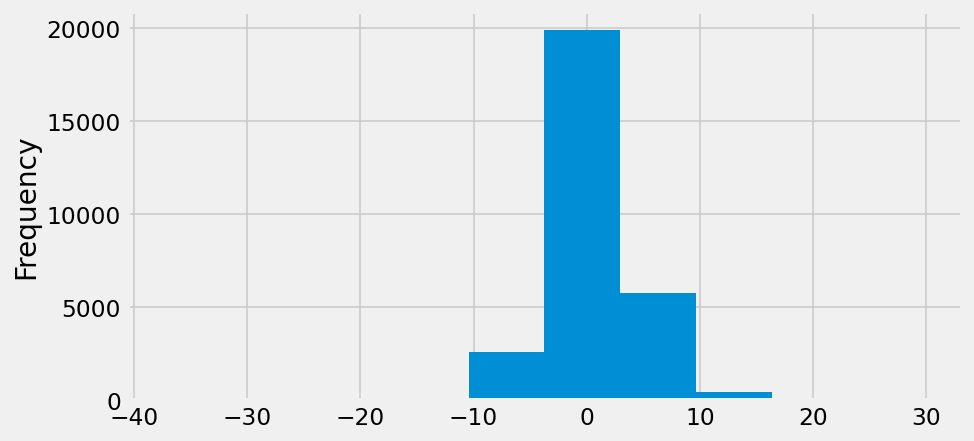

In [28]:
words_df.weights.plot(kind = 'hist')

In [37]:
words_df.sort_values(by = 'weights', inplace=True)

In [38]:
words_df.head(10)

,features,weights
27396,value,-37.291377
12988,inexpensive,-31.617026
19829,price,-30.282887
4057,buy,-28.904698
2430,bargain,-27.736884
3881,budget,-25.464328
1,000,-23.894786
922,affordable,-22.914561
3909,bulgarian,-21.440746
27398,values,-21.094290


In [39]:
words_df.tail(10)

,features,weights
2669,beerenauslese,24.037892
14561,levity,24.254556
558,97,24.710114
4881,champagne,25.079730
279,2020,25.225217
8586,eiswein,25.301039
1299,amarone,26.264290
3807,brunello,26.619712
282,2022,28.412417
25540,tba,29.819402


most of these are wine names.

__As we have seen above, most of the weights are given by only three columns.__   
__We can get comparebale results without using all columns__

In [40]:
%%time

selected_cols = ['designation','winery','location']

X_train, X_test, y_train, y_test, fmk = select_features(df_dev, selected_cols,
                                                              n_features='all', 
                                                              min_df= 1e-3,                                                       
                                                             )
ridge_top_3 = Ridge(random_state=rs)
ridge_top_3.fit(X_train, y_train)
y_hat = ridge_top_3.predict(X_test)
r2 = r2_score(y_test, y_hat)

print("With columns:", selected_cols, "\nr2-score:", r2)

(85028, 45635) 2
With columns: ['designation', 'winery', 'location'] 
r2-score: 0.7551424974015608
Wall time: 4.73 s


__it is clear now that model is mostly using 'designation','winery' and 'location' to predict__
  
let us find out what is the maximum score we can achieve from ridge, using also tfidf features.

In [52]:
cols = ['country', 'designation', 'location', 'region_2', 'variety', 'winery']

X_train, X_test, y_train, y_test, fmk = select_features(df_dev,
                                                        cols,  # all columns
                                                        n_features='all',
                                                        kind = 'both',
                                                        # no lower bound on document freq.
                                                        min_df=0,
                                                        # considering uni and bigrams
                                                        ng_range=(1, 3)
                                                        )

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  warni

(85028, 1934335) 2


In [53]:
%%time

ridge_all_in = Ridge(alpha = 0.5, tol = 1e-3, random_state=rs)
ridge_all_in.fit(X_train, y_train)
y_hat = ridge_all_in.predict(X_test)
r2 = r2_score(y_test, y_hat)

print("With features:", cols, "\nr2-score:", r2)

With features: ['country', 'designation', 'location', 'region_2', 'variety', 'winery'] 
r2-score: 0.758263879854777
Wall time: 39.3 s


#### Hyperparameters tuning for ridge

In [41]:
X_train, X_test, y_train, y_test, fmk = select_features(df_dev, selected_cols,
                                                              n_features='all', 
                                                              min_df= 1e-3,
                                                             )

(85028, 45635) 2


In [42]:
ridge = Ridge(random_state= rs)
ridge_params = {
    "alpha": [0.4,0.5,0.6,0.7,0.8],
    "tol": [1e-2,1e-3,1e-4],
#    "fit_intercept" : [True, False]
}

ri_search = GridSearchCV(ridge, param_grid= ridge_params, cv = 5, scoring= 'r2')
ri_search.fit(X_train, y_train)
ri_search.best_params_, ri_search.best_score_

({'alpha': 0.7, 'tol': 0.0001}, 0.7360595760256835)

In [43]:
y_hat = ri_search.predict(X_test)
r2_score(y_test, y_hat)

0.7574981279838393

In [380]:
mean_squared_error(y_test, y_hat)

34.86046347105496

In [44]:
from sklearn.model_selection import cross_val_score

In [57]:
from scipy.sparse import vstack

In [59]:
vstack((X_train, X_test)).shape

(85028, 45635)

In [64]:
X_c = vstack((X_train, X_test))
y_c = np.hstack((y_train, y_test))

In [53]:
np.vstack((X_train, X_test)).shape

(2, 1)

In [65]:
ridge = Ridge(0.7, tol = 1e-4, random_state=rs)
r2 = cross_val_score(ridge, X_c, y_c, n_jobs = -1, cv = 5, scoring = 'r2')


In [66]:
r2

array([0.75138261, 0.75014679, 0.74858523, 0.75193982, 0.75749649])

In [67]:
np.mean(r2)

0.7519101866109252

In [68]:
np.std(r2)

0.003021617005682084

In [74]:
rmse = cross_val_score(ridge, X_c, y_c, n_jobs = -1, cv = 5, scoring = 'neg_root_mean_squared_error')

In [75]:
rmse.mean()

-5.944782850441437

In [76]:
rmse.std()

0.052225145150914414

#### Hyperparameters tuning for RF regressor.

first we will try to select optimal number of features to select from svd.

In [79]:
df_dev.nunique()

country           49
description    85005
designation    27636
province         445
region_1        1206
region_2          18
variety          603
winery         14102
location        1590
dtype: int64

In [87]:
df_dev.columns

Index(['country', 'description', 'designation', 'province', 'region_1',
       'region_2', 'variety', 'winery', 'location'],
      dtype='object')

In [300]:
rf_cols = ['country', 'designation', 'province', 'location','variety', 'winery']

In [307]:
column_variance = {}
n = 100
for column in rf_cols:
    X_train, X_test, y_train, y_test, fmk = select_features(df_dev, [column],
                                                              n_features='all',
                                                              kind='cats'
                                                              )
    m = n if n < X_train.shape[1] else X_train.shape[1]//2
    svd = TruncatedSVD(n_components=m, random_state=rs)
    svd.fit(X_train, y_train)
    column_variance[column] = svd.explained_variance_ratio_

(85028, 49) 1
(85028, 27636) 1
(85028, 445) 1
(85028, 1591) 1
(85028, 603) 1
(85028, 14102) 1


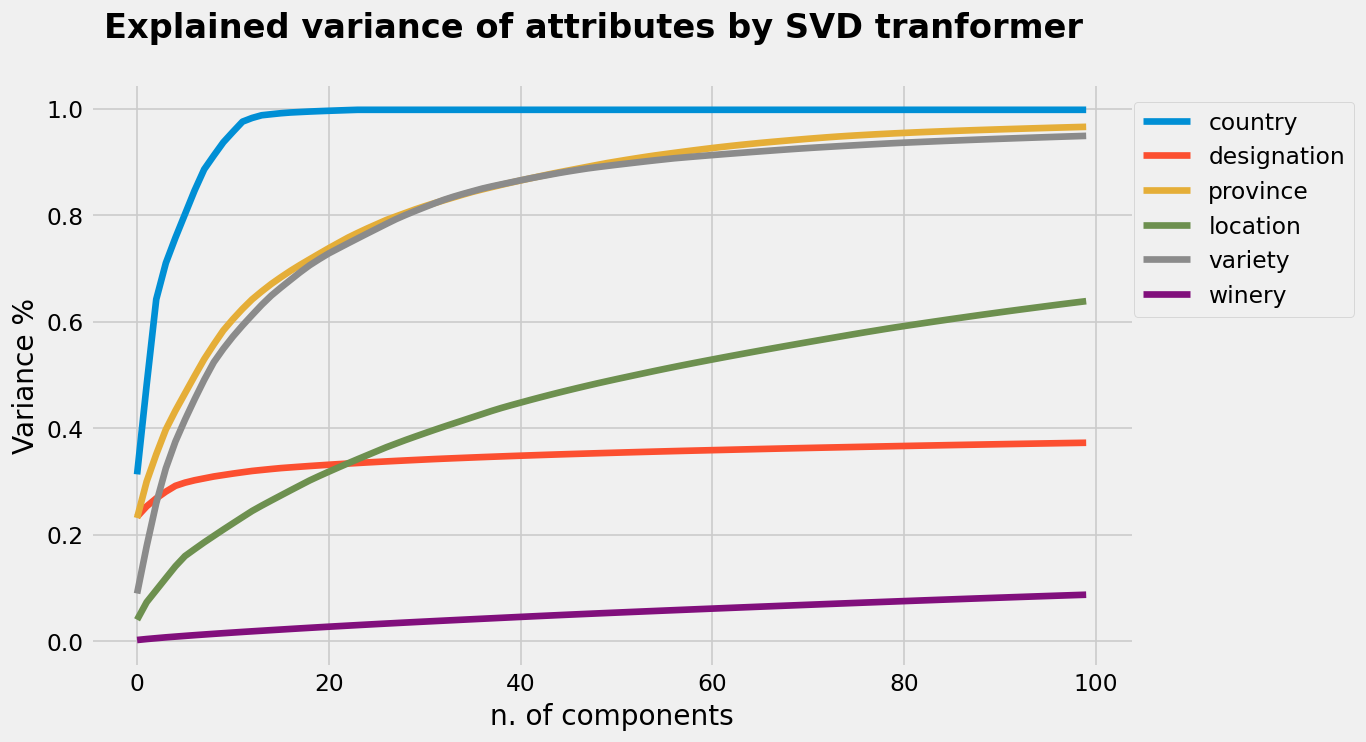

In [362]:
tmp = np.zeros(100)
tmp[:len(column_variance['country'])] = column_variance['country']
column_variance['country'] = tmp

for column in column_variance:
    plt.plot(np.cumsum(column_variance[column]), label = column)
    
f = plt.gcf()
f.suptitle("Explained variance of attributes by SVD tranformer")
plt.legend(loc = (1,.6))
plt.xlabel("n. of components");
plt.ylabel("Variance %")

plt.savefig("SVDExplainedAllCats.png", bbox_inches = 'tight')

In [160]:
rf_cols = ['province', 'variety']
n = 100
X_train, X_test, y_train, y_test, fmk = select_features(df_dev, rf_cols,
                                                        n_features='all',
                                                        kind='cats'
                                                        )
svd = TruncatedSVD(n_components=n, random_state=rs)
svd.fit(X_train, y_train)
explained_variance_ratio = svd.explained_variance_ratio_

(85028, 1048) 1


Text(0, 0.5, 'explained variance %')

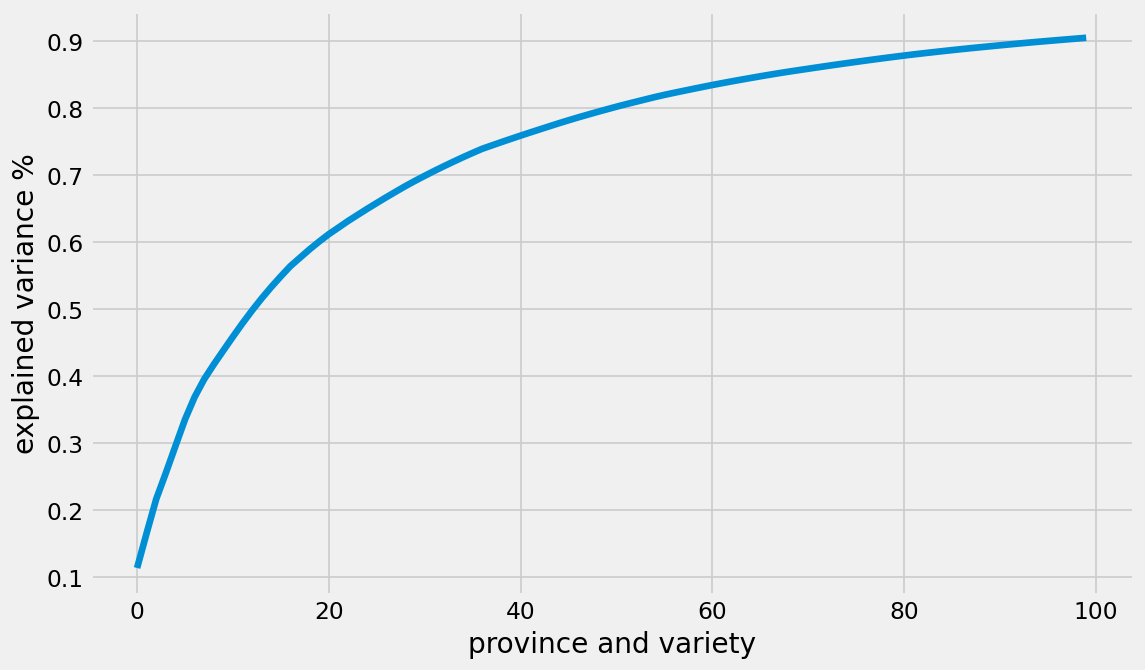

In [161]:
plt.plot(np.cumsum(explained_variance_ratio))
plt.xlabel("province and variety")
plt.ylabel("explained variance %")

In [69]:
rf_cols = ['province', 'variety']
n = 100
X_train, X_test, y_train, y_test, fmk = select_features(df_dev, rf_cols,
                                                        n_features='all',
                                                        kind='both',
                                                        min_df=1e-2
                                                        )
svd = TruncatedSVD(n_components=n, random_state=rs)
svd.fit(X_train, y_train)
explained_variance_ratio = svd.explained_variance_ratio_

(85028, 1436) 2


In [314]:
explained_variance_ratio

array([0.06986584, 0.02690405, 0.03304575, 0.03493436, 0.02985253,
       0.02722224, 0.02274808, 0.01682224, 0.01754668, 0.0154914 ,
       0.01466049, 0.01395048, 0.0131499 , 0.0128926 , 0.01190433,
       0.01114752, 0.01059482, 0.009267  , 0.00876003, 0.0086619 ,
       0.00796335, 0.00736116, 0.00681317, 0.00655219, 0.00634946,
       0.0060618 , 0.00596138, 0.00576785, 0.00557938, 0.00535084,
       0.00524675, 0.00509096, 0.00488679, 0.00469778, 0.00465288,
       0.00433293, 0.00428622, 0.0038012 , 0.00366543, 0.00352023,
       0.00345189, 0.00338871, 0.00322997, 0.00320882, 0.00316958,
       0.00311754, 0.00299911, 0.00296448, 0.00292736, 0.00283284,
       0.00281945, 0.00272946, 0.00271474, 0.00262071, 0.00255855,
       0.00248786, 0.00244469, 0.00239074, 0.00236387, 0.00230788,
       0.00222275, 0.00219632, 0.00217983, 0.00215377, 0.0021112 ,
       0.00208617, 0.00202888, 0.00201126, 0.00198521, 0.0019459 ,
       0.00193716, 0.00190659, 0.00189081, 0.00185568, 0.00183

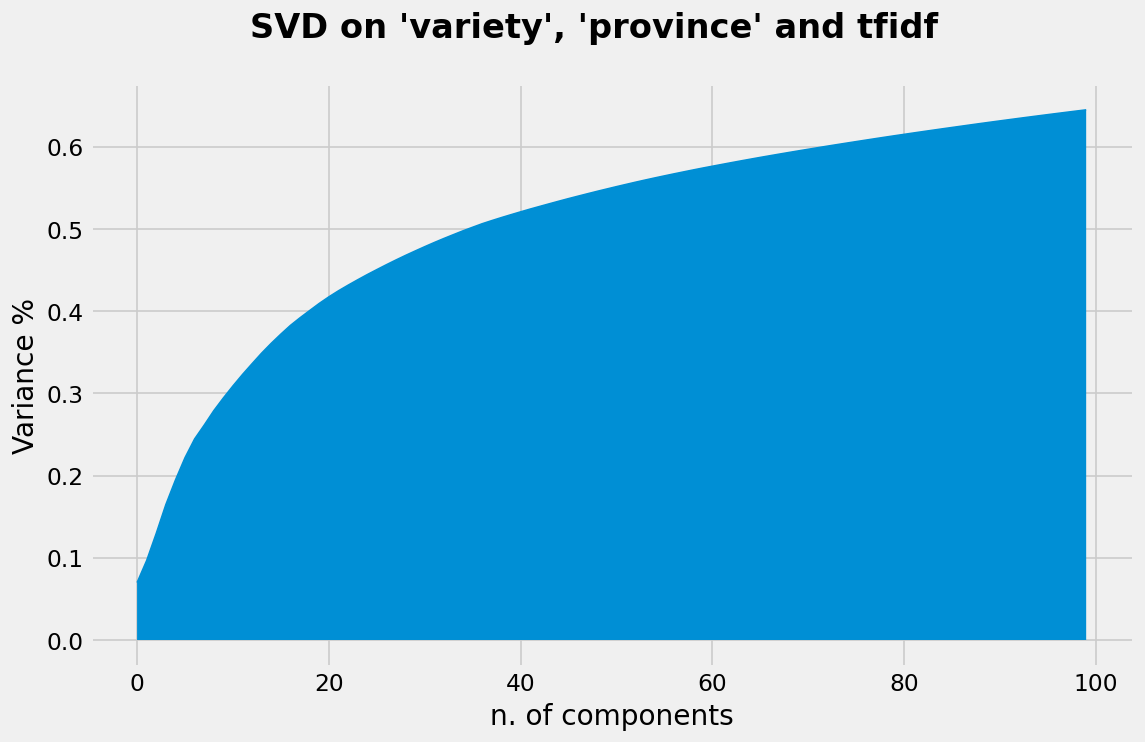

In [363]:

plt.plot(np.cumsum(explained_variance_ratio), linewidth = 0.9)

plt.fill_between(np.arange(100), np.cumsum(explained_variance_ratio))

plt.suptitle("SVD on 'variety', 'province' and tfidf")
plt.xlabel(f"n. of components")
plt.ylabel("Variance %");

plt.savefig("SVD_vpt.png", bbox_inches = 'tight')

In [114]:
len(fmk.top_words)

388

In [70]:
X_train_tr = svd.transform(X_train)
X_test_tr = svd.transform(X_test)

In [393]:
rfr = RandomForestRegressor(random_state= rs, n_jobs= -1)
rf_pl = make_pipeline(rfr)

sr_params = {
    "randomforestregressor__n_estimators": [20, 40, 60],
     #"randomforestregressor__max_features": ["sqrt","log2"]
}

rf_search = GridSearchCV(rf_pl, param_grid= sr_params, cv = 3, scoring= 'r2')
rf_search.fit(X_train_tr, y_train)

Pipeline(steps=[('randomforestregressor',
                 RandomForestRegressor(n_estimators=60, n_jobs=-1,
                                       random_state=999))])

In [382]:
rf_search.best_params_, rf_search.best_score_

({'randomforestregressor__n_estimators': 60}, 0.44385398648441843)

In [394]:
y_hat = rf_search.predict(X_test_tr)
r2_score(y_test, y_hat)

0.45487887493457346

In [78]:
X_rf = np.vstack((X_train_tr, X_test_tr))
X_rf.shape

(85028, 100)

In [80]:
y_rf = np.hstack((y_train, y_test))
y_rf.shape

(85028,)

In [81]:
rf = RandomForestRegressor(n_estimators=60)
r2 = cross_val_score(rf, X_rf, y_rf, n_jobs = -1, cv = 5, scoring = 'r2')
rmse = cross_val_score(rf, X_rf, y_rf, n_jobs = -1, cv = 5, scoring = 'neg_root_mean_squared_error')

In [83]:
r2.mean(), r2.std()

(0.4536332773693318, 0.0025123086472197843)

In [85]:
rmse.mean(), rmse.std()

(-8.813579943037977, 0.0634582938540922)

In [387]:
X_eval = fmk.transform(df_eval)

In [110]:
#for ridge
y_hat = ri_search.predict(X_eval)

In [388]:
#for random forest
y_hat = rf_search.predict(svd.transform(X_eval))

ValueError: X has 100 features, but DecisionTreeRegressor is expecting 45188 features as input.

In [176]:
create_results_file(y_hat)

In [178]:
df_eval.shape[0]/df_dev.shape[0]

0.3550124664816296

In [179]:
df_eval.duplicated().sum()

2595